<h3>Objective:</h3>Use machine learning to detect fraud transactions

In [2]:
#load packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#load the dataset
training_data = pd.read_csv("./data/training.csv")
test_data = pd.read_csv("./data/test.csv")


In [3]:
#Data Exploration
#check the data  types & any missing values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [4]:
#explore the data:take a look at the top data
training_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [5]:
#Data Transformation
#Feature engineer the start times
#Take a snapshot of the data so we know it's structure
training_data['TransactionStartTime'][:10]

0    2018-11-15T02:18:49Z
1    2018-11-15T02:19:08Z
2    2018-11-15T02:44:21Z
3    2018-11-15T03:32:55Z
4    2018-11-15T03:34:21Z
5    2018-11-15T03:35:10Z
6    2018-11-15T03:44:31Z
7    2018-11-15T03:45:13Z
8    2018-11-15T04:14:59Z
9    2018-11-15T04:31:48Z
Name: TransactionStartTime, dtype: object

In [6]:
#A function to extract year, month,day & hour from date column
def extract_date(data,column):
    '''The function take a dataframe and a column string arguments'''
    data["TransactionYear"]= data[column].apply(lambda x: x.year)
    data["TransactionMonth"]= data[column].apply(lambda x: x.month)
    data["TransactionDay"]= data[column].apply(lambda x: x.dayofweek)
    data["TransactionHour"]= data[column].apply(lambda x: x.time().hour)
    
    
#add date & Month to the data
#convert TransactionStartTime to data
training_data['TransactionStartTime'] = pd.to_datetime(training_data['TransactionStartTime'])
extract_date(training_data,'TransactionStartTime')


#classify day of transaction as either weekend or weekday
training_data['DayofWeek']= np.where(training_data['TransactionDay']>5,'Weekend','Weekday')
#classify the time of day into morning,afternoon,evening(/night)
time_conditions=[(training_data['TransactionHour'])>18,
                (training_data['TransactionHour'])>12,
                (training_data['TransactionHour'])>5]
time_choices=['Night','Afternoon','Morning']

#split the time 
training_data['TimeofDay']= np.select(time_conditions,time_choices,default='Night')
    

In [68]:
#check the values of the updated data
training_data[:10]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Value,TransactionStartTime,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,DayofWeek,TimeofDay
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,1000,2018-11-15 02:18:49,2,0,2018,11,3,2,Weekday,Night
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,20,2018-11-15 02:19:08,2,0,2018,11,3,2,Weekday,Night
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,500,2018-11-15 02:44:21,2,0,2018,11,3,2,Weekday,Night
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,21800,2018-11-15 03:32:55,2,0,2018,11,3,3,Weekday,Night
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,644,2018-11-15 03:34:21,2,0,2018,11,3,3,Weekday,Night
5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,...,2000,2018-11-15 03:35:10,2,0,2018,11,3,3,Weekday,Night
6,TransactionId_118063,BatchId_118460,AccountId_2442,SubscriptionId_1980,CustomerId_2858,UGX,256,ProviderId_5,ProductId_3,airtime,...,10000,2018-11-15 03:44:31,4,0,2018,11,3,3,Weekday,Night
7,TransactionId_100640,BatchId_38561,AccountId_4841,SubscriptionId_3829,CustomerId_2858,UGX,256,ProviderId_4,ProductId_6,financial_services,...,500,2018-11-15 03:45:13,2,0,2018,11,3,3,Weekday,Night
8,TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256,ProviderId_6,ProductId_10,airtime,...,500,2018-11-15 04:14:59,2,0,2018,11,3,4,Weekday,Night
9,TransactionId_130161,BatchId_82409,AccountId_710,SubscriptionId_920,CustomerId_1053,UGX,256,ProviderId_1,ProductId_15,financial_services,...,600,2018-11-15 04:31:48,2,0,2018,11,3,4,Weekday,Night


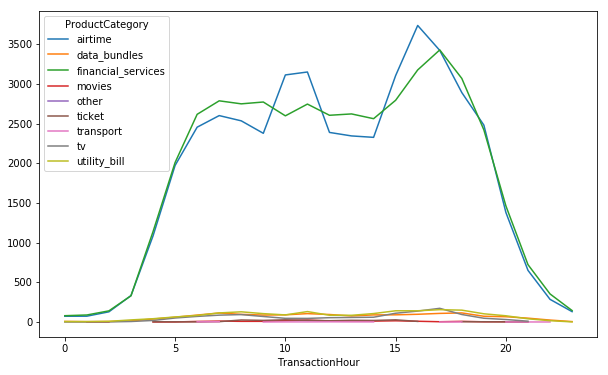

In [52]:
#Data Visualization
#plot the number of transactions by day
fig,ax = plt.subplots(figsize=(10,6))
#summaize transaction by time of day
#training_data.groupby(['TransactionHour','FraudResult']).count()['TransactionId'].unstack().plot.bar(ax=ax)
training_data.groupby(['TransactionHour','ProductCategory']).count()['TransactionId'].unstack().plot(ax=ax)

#plt.hist(training_data['TransactionDay']),
#plt.hist(training_data['TimeofDay'])

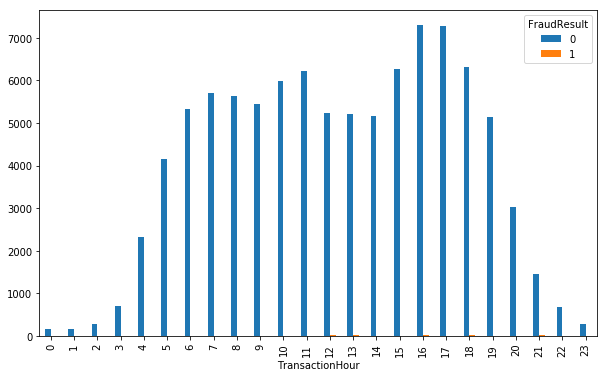

In [67]:
#check frequency of fraud transactions in a given hour
fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['TransactionHour','FraudResult']).count()['TransactionId'].unstack().plot.bar(ax=ax)

In [60]:
#Fraud Result by product category
#Finacial services has the highest number of fraud results
training_data.groupby(['ProductCategory','FraudResult']).count()['TransactionId']#.unstack().plot.bar(ax=ax)

ProductCategory     FraudResult
airtime             0              45009
                    1                 18
data_bundles        0               1613
financial_services  0              45244
                    1                161
movies              0                175
other               0                  2
ticket              0                216
transport           0                 23
                    1                  2
tv                  0               1279
utility_bill        0               1908
                    1                 12
Name: TransactionId, dtype: int64

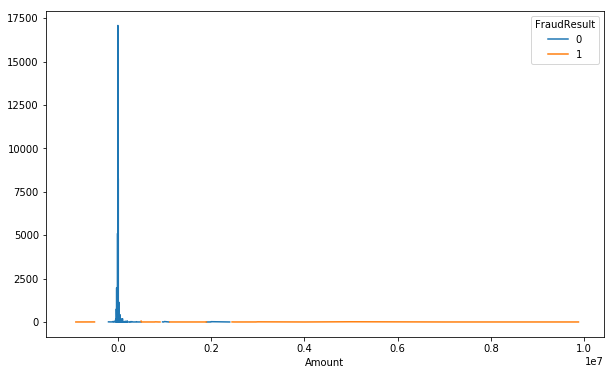

In [66]:
#compare fraud and transaction amount
#Transactions below 0 are fradulent & majority of transactions more 1000000 are fraudulent
fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['Amount','FraudResult']).count()['TransactionId'].unstack().plot(ax=ax)

In [71]:
#compare fraud results by provider 
#Providers 3 & 5 have the highest number of fraudulent transactions
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['ProviderId','FraudResult']).count()['TransactionId']#.unstack().plot(ax=ax)

ProviderId    FraudResult
ProviderId_1  0               5586
              1                 57
ProviderId_2  0                 18
ProviderId_3  0               3020
              1                 64
ProviderId_4  0              38184
              1                  5
ProviderId_5  0              14478
              1                 64
ProviderId_6  0              34183
              1                  3
Name: TransactionId, dtype: int64

In [83]:
#compare fraud results by product type
#Product 15 has highest number of fraudulent transactions
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['ProductId','FraudResult']).count()['TransactionId']#.unstack().plot.bar(ax=ax)

ProductId     FraudResult
ProductId_1   0               2885
ProductId_10  0              15378
              1                  6
ProductId_11  0               1377
ProductId_12  0                  2
ProductId_13  0                290
              1                  6
ProductId_14  0                789
ProductId_15  0              11807
              1                157
ProductId_16  0                 10
ProductId_19  0                965
ProductId_2   0                236
ProductId_20  0                216
ProductId_21  0               1508
              1                  4
ProductId_22  0                110
              1                  2
ProductId_23  0                  1
ProductId_24  0                175
ProductId_27  0                 31
ProductId_3   0              24332
              1                 12
ProductId_4   0               2403
ProductId_5   0                 23
              1                  2
ProductId_6   0              32634
              1              

In [79]:
#compare fraud results by pricing strategy
#Pricing Strategy 2 has the highest number of fraudulent transactions
#Pricing Strategy 0 has highest % of fraudulent transactions (10%)
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['PricingStrategy','FraudResult']).count()['TransactionId']#.unstack().plot(ax=ax)

PricingStrategy  FraudResult
0                0                349
                 1                 36
1                0               1860
                 1                  7
2                0              79709
                 1                139
4                0              13551
                 1                 11
Name: TransactionId, dtype: int64

In [77]:
(36/349)*100,(7/1860)*100,(139/79709)*100,(11/13551)*100

(10.315186246418339,
 0.3763440860215054,
 0.1743843229748209,
 0.08117482104641724)

In [17]:
#transaction summary : quick stats on numerical data
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


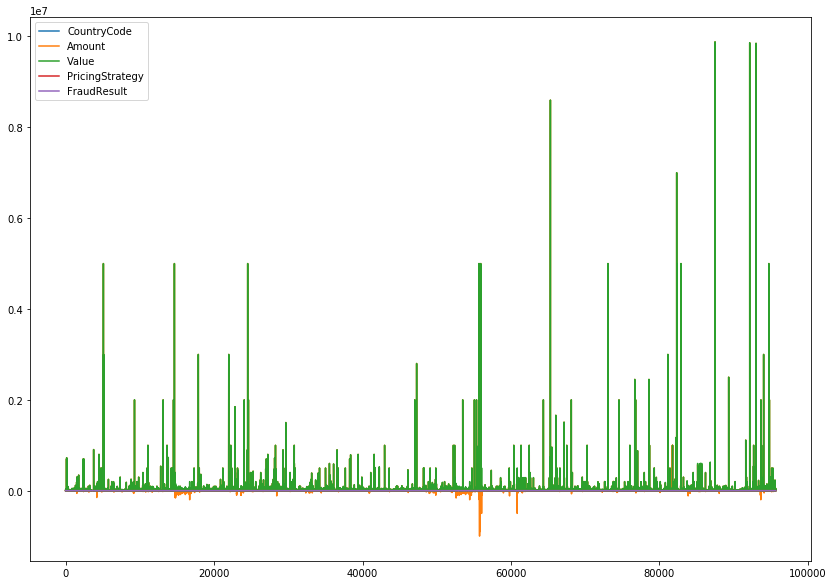

In [24]:
#plot the distribution of transaction amounts
training_data.plot(figsize=(14,10))

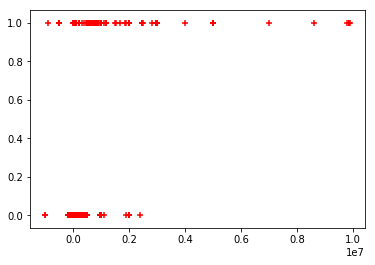

In [32]:
#plot the distribution of transaction amount &
#whether the transaction is fraudulent or not
plt.scatter(training_data.Amount,training_data.FraudResult,marker="+",color="red")

From plot above, we can see that there is no clear distiction between fraudulent & non-fraudulent transactions
for amounts that are less than 400,000. Higher transaction amounts have are more likely to be fraudulent.

In [34]:
training_data.shape

(95662, 16)

In [85]:
#split the training data into train & test data (80:20 split used)
#Get a dataframe of the features to use
Amount = pd.DataFrame(training_data.Amount)
FraudResult = pd.DataFrame(training_data.FraudResult)

#X_train to train the model & X_test to test the model
X_train,X_test,y_train,y_test=train_test_split(Amount,FraudResult,test_size=0.2,random_state=42)


In [50]:
#create object class of the model
model = LogisticRegression()

In [86]:
#train the model
#reshape the data
#X_train = X_train.values.reshape(1,-1)
#y_train = y_train.values.reshape(1,-1)
model.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
#predict the test
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [93]:
#score of the model
model.score(X_test,y_test)

0.9984320284325511

In [95]:
#check probability scores
model.predict_proba(X_test)

array([[0.99896231, 0.00103769],
       [0.99895287, 0.00104713],
       [0.99894652, 0.00105348],
       ...,
       [0.99895917, 0.00104083],
       [0.99896569, 0.00103431],
       [0.99890102, 0.00109898]])